# Classification with Decision Trees and Random Forests

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from classification_utils import *
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_validate
import statistics
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.decomposition import PCA

In [2]:
data = pd.read_csv("dataset/cleaned_user_profiles.csv", index_col=0)

In [3]:
data = data.join(pd.get_dummies(data["lang"]))

In [4]:
train_set, test_set, train_label, test_label = prepare_data(data)

Classification features : ['statuses_count', 'avg_length', 'avg_special_chars', 'urls_ratio', 'mentions_ratio', 'hashtags_ratio', 'reply_count_mean', 'reply_count_std', 'favorite_count_mean', 'favorite_count_std', 'favorite_count_entropy', 'retweet_count_mean', 'retweet_count_std', 'ar', 'da', 'de', 'el', 'en', 'es', 'fil', 'fr', 'id', 'it', 'ja', 'ko', 'nl', 'pl', 'pt', 'ru', 'sv', 'tr', 'zh']


## Decision trees

In [5]:
param_grid = {'max_features': ['auto', 'sqrt', 'log2'],
              'ccp_alpha': [0.1, 0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001, 0.5, 0.2],
              'max_depth' : np.arange(8, 25, 1),
              'criterion' :['gini', 'entropy']
             }


dt = tree.DecisionTreeClassifier()

grid = GridSearchCV(
    dt,
    param_grid,
    cv=5,
    scoring='accuracy',
    return_train_score=False,
    verbose=4
)


grid.fit(train_set, train_label)
print(
    "The best parameters are %s with a score of %0.5f"
    % (grid.best_params_, grid.best_score_)
)


Fitting 5 folds for each of 918 candidates, totalling 4590 fits
[CV 1/5] END ccp_alpha=0.1, criterion=gini, max_depth=8, max_features=auto;, score=0.761 total time=   0.0s
[CV 2/5] END ccp_alpha=0.1, criterion=gini, max_depth=8, max_features=auto;, score=0.869 total time=   0.0s
[CV 3/5] END ccp_alpha=0.1, criterion=gini, max_depth=8, max_features=auto;, score=0.531 total time=   0.0s
[CV 4/5] END ccp_alpha=0.1, criterion=gini, max_depth=8, max_features=auto;, score=0.858 total time=   0.0s
[CV 5/5] END ccp_alpha=0.1, criterion=gini, max_depth=8, max_features=auto;, score=0.855 total time=   0.0s
[CV 1/5] END ccp_alpha=0.1, criterion=gini, max_depth=8, max_features=sqrt;, score=0.761 total time=   0.0s
[CV 2/5] END ccp_alpha=0.1, criterion=gini, max_depth=8, max_features=sqrt;, score=0.869 total time=   0.0s
[CV 3/5] END ccp_alpha=0.1, criterion=gini, max_depth=8, max_features=sqrt;, score=0.762 total time=   0.0s
[CV 4/5] END ccp_alpha=0.1, criterion=gini, max_depth=8, max_features=sq

[CV 5/5] END ccp_alpha=0.1, criterion=gini, max_depth=13, max_features=log2;, score=0.532 total time=   0.0s
[CV 1/5] END ccp_alpha=0.1, criterion=gini, max_depth=14, max_features=auto;, score=0.827 total time=   0.0s
[CV 2/5] END ccp_alpha=0.1, criterion=gini, max_depth=14, max_features=auto;, score=0.531 total time=   0.0s
[CV 3/5] END ccp_alpha=0.1, criterion=gini, max_depth=14, max_features=auto;, score=0.531 total time=   0.0s
[CV 4/5] END ccp_alpha=0.1, criterion=gini, max_depth=14, max_features=auto;, score=0.747 total time=   0.0s
[CV 5/5] END ccp_alpha=0.1, criterion=gini, max_depth=14, max_features=auto;, score=0.855 total time=   0.0s
[CV 1/5] END ccp_alpha=0.1, criterion=gini, max_depth=14, max_features=sqrt;, score=0.827 total time=   0.0s
[CV 2/5] END ccp_alpha=0.1, criterion=gini, max_depth=14, max_features=sqrt;, score=0.531 total time=   0.0s
[CV 3/5] END ccp_alpha=0.1, criterion=gini, max_depth=14, max_features=sqrt;, score=0.852 total time=   0.0s
[CV 4/5] END ccp_al

[CV 2/5] END ccp_alpha=0.1, criterion=gini, max_depth=19, max_features=auto;, score=0.783 total time=   0.0s
[CV 3/5] END ccp_alpha=0.1, criterion=gini, max_depth=19, max_features=auto;, score=0.531 total time=   0.0s
[CV 4/5] END ccp_alpha=0.1, criterion=gini, max_depth=19, max_features=auto;, score=0.747 total time=   0.0s
[CV 5/5] END ccp_alpha=0.1, criterion=gini, max_depth=19, max_features=auto;, score=0.532 total time=   0.0s
[CV 1/5] END ccp_alpha=0.1, criterion=gini, max_depth=19, max_features=sqrt;, score=0.819 total time=   0.0s
[CV 2/5] END ccp_alpha=0.1, criterion=gini, max_depth=19, max_features=sqrt;, score=0.754 total time=   0.0s
[CV 3/5] END ccp_alpha=0.1, criterion=gini, max_depth=19, max_features=sqrt;, score=0.531 total time=   0.0s
[CV 4/5] END ccp_alpha=0.1, criterion=gini, max_depth=19, max_features=sqrt;, score=0.858 total time=   0.0s
[CV 5/5] END ccp_alpha=0.1, criterion=gini, max_depth=19, max_features=sqrt;, score=0.532 total time=   0.0s
[CV 1/5] END ccp_al

[CV 4/5] END ccp_alpha=0.1, criterion=gini, max_depth=24, max_features=log2;, score=0.747 total time=   0.0s
[CV 5/5] END ccp_alpha=0.1, criterion=gini, max_depth=24, max_features=log2;, score=0.532 total time=   0.0s
[CV 1/5] END ccp_alpha=0.1, criterion=entropy, max_depth=8, max_features=auto;, score=0.761 total time=   0.0s
[CV 2/5] END ccp_alpha=0.1, criterion=entropy, max_depth=8, max_features=auto;, score=0.785 total time=   0.0s
[CV 3/5] END ccp_alpha=0.1, criterion=entropy, max_depth=8, max_features=auto;, score=0.749 total time=   0.0s
[CV 4/5] END ccp_alpha=0.1, criterion=entropy, max_depth=8, max_features=auto;, score=0.832 total time=   0.0s
[CV 5/5] END ccp_alpha=0.1, criterion=entropy, max_depth=8, max_features=auto;, score=0.839 total time=   0.0s
[CV 1/5] END ccp_alpha=0.1, criterion=entropy, max_depth=8, max_features=sqrt;, score=0.761 total time=   0.0s
[CV 2/5] END ccp_alpha=0.1, criterion=entropy, max_depth=8, max_features=sqrt;, score=0.765 total time=   0.0s
[CV 3

[CV 2/5] END ccp_alpha=0.1, criterion=entropy, max_depth=13, max_features=sqrt;, score=0.706 total time=   0.0s
[CV 3/5] END ccp_alpha=0.1, criterion=entropy, max_depth=13, max_features=sqrt;, score=0.741 total time=   0.0s
[CV 4/5] END ccp_alpha=0.1, criterion=entropy, max_depth=13, max_features=sqrt;, score=0.666 total time=   0.0s
[CV 5/5] END ccp_alpha=0.1, criterion=entropy, max_depth=13, max_features=sqrt;, score=0.839 total time=   0.0s
[CV 1/5] END ccp_alpha=0.1, criterion=entropy, max_depth=13, max_features=log2;, score=0.531 total time=   0.0s
[CV 2/5] END ccp_alpha=0.1, criterion=entropy, max_depth=13, max_features=log2;, score=0.794 total time=   0.0s
[CV 3/5] END ccp_alpha=0.1, criterion=entropy, max_depth=13, max_features=log2;, score=0.741 total time=   0.0s
[CV 4/5] END ccp_alpha=0.1, criterion=entropy, max_depth=13, max_features=log2;, score=0.742 total time=   0.0s
[CV 5/5] END ccp_alpha=0.1, criterion=entropy, max_depth=13, max_features=log2;, score=0.833 total time=

[CV 1/5] END ccp_alpha=0.1, criterion=entropy, max_depth=19, max_features=sqrt;, score=0.761 total time=   0.0s
[CV 2/5] END ccp_alpha=0.1, criterion=entropy, max_depth=19, max_features=sqrt;, score=0.531 total time=   0.0s
[CV 3/5] END ccp_alpha=0.1, criterion=entropy, max_depth=19, max_features=sqrt;, score=0.741 total time=   0.0s
[CV 4/5] END ccp_alpha=0.1, criterion=entropy, max_depth=19, max_features=sqrt;, score=0.748 total time=   0.0s
[CV 5/5] END ccp_alpha=0.1, criterion=entropy, max_depth=19, max_features=sqrt;, score=0.855 total time=   0.0s
[CV 1/5] END ccp_alpha=0.1, criterion=entropy, max_depth=19, max_features=log2;, score=0.761 total time=   0.0s
[CV 2/5] END ccp_alpha=0.1, criterion=entropy, max_depth=19, max_features=log2;, score=0.751 total time=   0.0s
[CV 3/5] END ccp_alpha=0.1, criterion=entropy, max_depth=19, max_features=log2;, score=0.845 total time=   0.0s
[CV 4/5] END ccp_alpha=0.1, criterion=entropy, max_depth=19, max_features=log2;, score=0.848 total time=

[CV 4/5] END ccp_alpha=0.1, criterion=entropy, max_depth=24, max_features=sqrt;, score=0.531 total time=   0.0s
[CV 5/5] END ccp_alpha=0.1, criterion=entropy, max_depth=24, max_features=sqrt;, score=0.532 total time=   0.0s
[CV 1/5] END ccp_alpha=0.1, criterion=entropy, max_depth=24, max_features=log2;, score=0.531 total time=   0.0s
[CV 2/5] END ccp_alpha=0.1, criterion=entropy, max_depth=24, max_features=log2;, score=0.531 total time=   0.0s
[CV 3/5] END ccp_alpha=0.1, criterion=entropy, max_depth=24, max_features=log2;, score=0.852 total time=   0.0s
[CV 4/5] END ccp_alpha=0.1, criterion=entropy, max_depth=24, max_features=log2;, score=0.858 total time=   0.0s
[CV 5/5] END ccp_alpha=0.1, criterion=entropy, max_depth=24, max_features=log2;, score=0.687 total time=   0.0s
[CV 1/5] END ccp_alpha=0.05, criterion=gini, max_depth=8, max_features=auto;, score=0.737 total time=   0.0s
[CV 2/5] END ccp_alpha=0.05, criterion=gini, max_depth=8, max_features=auto;, score=0.795 total time=   0.0

[CV 4/5] END ccp_alpha=0.05, criterion=gini, max_depth=13, max_features=sqrt;, score=0.689 total time=   0.0s
[CV 5/5] END ccp_alpha=0.05, criterion=gini, max_depth=13, max_features=sqrt;, score=0.754 total time=   0.0s
[CV 1/5] END ccp_alpha=0.05, criterion=gini, max_depth=13, max_features=log2;, score=0.732 total time=   0.0s
[CV 2/5] END ccp_alpha=0.05, criterion=gini, max_depth=13, max_features=log2;, score=0.531 total time=   0.0s
[CV 3/5] END ccp_alpha=0.05, criterion=gini, max_depth=13, max_features=log2;, score=0.690 total time=   0.0s
[CV 4/5] END ccp_alpha=0.05, criterion=gini, max_depth=13, max_features=log2;, score=0.666 total time=   0.0s
[CV 5/5] END ccp_alpha=0.05, criterion=gini, max_depth=13, max_features=log2;, score=0.532 total time=   0.0s
[CV 1/5] END ccp_alpha=0.05, criterion=gini, max_depth=14, max_features=auto;, score=0.761 total time=   0.0s
[CV 2/5] END ccp_alpha=0.05, criterion=gini, max_depth=14, max_features=auto;, score=0.757 total time=   0.0s
[CV 3/5] E

[CV 1/5] END ccp_alpha=0.05, criterion=gini, max_depth=18, max_features=log2;, score=0.737 total time=   0.0s
[CV 2/5] END ccp_alpha=0.05, criterion=gini, max_depth=18, max_features=log2;, score=0.858 total time=   0.0s
[CV 3/5] END ccp_alpha=0.05, criterion=gini, max_depth=18, max_features=log2;, score=0.711 total time=   0.0s
[CV 4/5] END ccp_alpha=0.05, criterion=gini, max_depth=18, max_features=log2;, score=0.742 total time=   0.0s
[CV 5/5] END ccp_alpha=0.05, criterion=gini, max_depth=18, max_features=log2;, score=0.721 total time=   0.0s
[CV 1/5] END ccp_alpha=0.05, criterion=gini, max_depth=19, max_features=auto;, score=0.677 total time=   0.0s
[CV 2/5] END ccp_alpha=0.05, criterion=gini, max_depth=19, max_features=auto;, score=0.783 total time=   0.0s
[CV 3/5] END ccp_alpha=0.05, criterion=gini, max_depth=19, max_features=auto;, score=0.785 total time=   0.0s
[CV 4/5] END ccp_alpha=0.05, criterion=gini, max_depth=19, max_features=auto;, score=0.829 total time=   0.0s
[CV 5/5] E

[CV 3/5] END ccp_alpha=0.05, criterion=gini, max_depth=24, max_features=log2;, score=0.891 total time=   0.0s
[CV 4/5] END ccp_alpha=0.05, criterion=gini, max_depth=24, max_features=log2;, score=0.840 total time=   0.0s
[CV 5/5] END ccp_alpha=0.05, criterion=gini, max_depth=24, max_features=log2;, score=0.687 total time=   0.0s
[CV 1/5] END ccp_alpha=0.05, criterion=entropy, max_depth=8, max_features=auto;, score=0.841 total time=   0.0s
[CV 2/5] END ccp_alpha=0.05, criterion=entropy, max_depth=8, max_features=auto;, score=0.723 total time=   0.0s
[CV 3/5] END ccp_alpha=0.05, criterion=entropy, max_depth=8, max_features=auto;, score=0.712 total time=   0.0s
[CV 4/5] END ccp_alpha=0.05, criterion=entropy, max_depth=8, max_features=auto;, score=0.742 total time=   0.0s
[CV 5/5] END ccp_alpha=0.05, criterion=entropy, max_depth=8, max_features=auto;, score=0.771 total time=   0.0s
[CV 1/5] END ccp_alpha=0.05, criterion=entropy, max_depth=8, max_features=sqrt;, score=0.822 total time=   0.0

[CV 1/5] END ccp_alpha=0.05, criterion=entropy, max_depth=13, max_features=sqrt;, score=0.737 total time=   0.0s
[CV 2/5] END ccp_alpha=0.05, criterion=entropy, max_depth=13, max_features=sqrt;, score=0.775 total time=   0.0s
[CV 3/5] END ccp_alpha=0.05, criterion=entropy, max_depth=13, max_features=sqrt;, score=0.802 total time=   0.0s
[CV 4/5] END ccp_alpha=0.05, criterion=entropy, max_depth=13, max_features=sqrt;, score=0.777 total time=   0.0s
[CV 5/5] END ccp_alpha=0.05, criterion=entropy, max_depth=13, max_features=sqrt;, score=0.828 total time=   0.0s
[CV 1/5] END ccp_alpha=0.05, criterion=entropy, max_depth=13, max_features=log2;, score=0.811 total time=   0.0s
[CV 2/5] END ccp_alpha=0.05, criterion=entropy, max_depth=13, max_features=log2;, score=0.801 total time=   0.0s
[CV 3/5] END ccp_alpha=0.05, criterion=entropy, max_depth=13, max_features=log2;, score=0.785 total time=   0.0s
[CV 4/5] END ccp_alpha=0.05, criterion=entropy, max_depth=13, max_features=log2;, score=0.858 to

[CV 4/5] END ccp_alpha=0.05, criterion=entropy, max_depth=19, max_features=auto;, score=0.876 total time=   0.0s
[CV 5/5] END ccp_alpha=0.05, criterion=entropy, max_depth=19, max_features=auto;, score=0.742 total time=   0.0s
[CV 1/5] END ccp_alpha=0.05, criterion=entropy, max_depth=19, max_features=sqrt;, score=0.678 total time=   0.0s
[CV 2/5] END ccp_alpha=0.05, criterion=entropy, max_depth=19, max_features=sqrt;, score=0.869 total time=   0.0s
[CV 3/5] END ccp_alpha=0.05, criterion=entropy, max_depth=19, max_features=sqrt;, score=0.741 total time=   0.0s
[CV 4/5] END ccp_alpha=0.05, criterion=entropy, max_depth=19, max_features=sqrt;, score=0.748 total time=   0.0s
[CV 5/5] END ccp_alpha=0.05, criterion=entropy, max_depth=19, max_features=sqrt;, score=0.870 total time=   0.0s
[CV 1/5] END ccp_alpha=0.05, criterion=entropy, max_depth=19, max_features=log2;, score=0.731 total time=   0.0s
[CV 2/5] END ccp_alpha=0.05, criterion=entropy, max_depth=19, max_features=log2;, score=0.869 to

[CV 3/5] END ccp_alpha=0.05, criterion=entropy, max_depth=24, max_features=sqrt;, score=0.776 total time=   0.0s
[CV 4/5] END ccp_alpha=0.05, criterion=entropy, max_depth=24, max_features=sqrt;, score=0.858 total time=   0.0s
[CV 5/5] END ccp_alpha=0.05, criterion=entropy, max_depth=24, max_features=sqrt;, score=0.759 total time=   0.0s
[CV 1/5] END ccp_alpha=0.05, criterion=entropy, max_depth=24, max_features=log2;, score=0.731 total time=   0.0s
[CV 2/5] END ccp_alpha=0.05, criterion=entropy, max_depth=24, max_features=log2;, score=0.751 total time=   0.0s
[CV 3/5] END ccp_alpha=0.05, criterion=entropy, max_depth=24, max_features=log2;, score=0.891 total time=   0.0s
[CV 4/5] END ccp_alpha=0.05, criterion=entropy, max_depth=24, max_features=log2;, score=0.748 total time=   0.0s
[CV 5/5] END ccp_alpha=0.05, criterion=entropy, max_depth=24, max_features=log2;, score=0.855 total time=   0.0s
[CV 1/5] END ccp_alpha=0.01, criterion=gini, max_depth=8, max_features=auto;, score=0.831 total 

[CV 2/5] END ccp_alpha=0.01, criterion=gini, max_depth=13, max_features=sqrt;, score=0.834 total time=   0.0s
[CV 3/5] END ccp_alpha=0.01, criterion=gini, max_depth=13, max_features=sqrt;, score=0.852 total time=   0.0s
[CV 4/5] END ccp_alpha=0.01, criterion=gini, max_depth=13, max_features=sqrt;, score=0.856 total time=   0.0s
[CV 5/5] END ccp_alpha=0.01, criterion=gini, max_depth=13, max_features=sqrt;, score=0.806 total time=   0.0s
[CV 1/5] END ccp_alpha=0.01, criterion=gini, max_depth=13, max_features=log2;, score=0.817 total time=   0.0s
[CV 2/5] END ccp_alpha=0.01, criterion=gini, max_depth=13, max_features=log2;, score=0.818 total time=   0.0s
[CV 3/5] END ccp_alpha=0.01, criterion=gini, max_depth=13, max_features=log2;, score=0.842 total time=   0.0s
[CV 4/5] END ccp_alpha=0.01, criterion=gini, max_depth=13, max_features=log2;, score=0.858 total time=   0.0s
[CV 5/5] END ccp_alpha=0.01, criterion=gini, max_depth=13, max_features=log2;, score=0.818 total time=   0.0s
[CV 1/5] E

[CV 1/5] END ccp_alpha=0.01, criterion=gini, max_depth=18, max_features=log2;, score=0.870 total time=   0.0s
[CV 2/5] END ccp_alpha=0.01, criterion=gini, max_depth=18, max_features=log2;, score=0.869 total time=   0.0s
[CV 3/5] END ccp_alpha=0.01, criterion=gini, max_depth=18, max_features=log2;, score=0.836 total time=   0.0s
[CV 4/5] END ccp_alpha=0.01, criterion=gini, max_depth=18, max_features=log2;, score=0.818 total time=   0.0s
[CV 5/5] END ccp_alpha=0.01, criterion=gini, max_depth=18, max_features=log2;, score=0.818 total time=   0.0s
[CV 1/5] END ccp_alpha=0.01, criterion=gini, max_depth=19, max_features=auto;, score=0.810 total time=   0.0s
[CV 2/5] END ccp_alpha=0.01, criterion=gini, max_depth=19, max_features=auto;, score=0.788 total time=   0.0s
[CV 3/5] END ccp_alpha=0.01, criterion=gini, max_depth=19, max_features=auto;, score=0.772 total time=   0.0s
[CV 4/5] END ccp_alpha=0.01, criterion=gini, max_depth=19, max_features=auto;, score=0.883 total time=   0.0s
[CV 5/5] E

[CV 2/5] END ccp_alpha=0.01, criterion=gini, max_depth=24, max_features=log2;, score=0.853 total time=   0.0s
[CV 3/5] END ccp_alpha=0.01, criterion=gini, max_depth=24, max_features=log2;, score=0.758 total time=   0.0s
[CV 4/5] END ccp_alpha=0.01, criterion=gini, max_depth=24, max_features=log2;, score=0.765 total time=   0.0s
[CV 5/5] END ccp_alpha=0.01, criterion=gini, max_depth=24, max_features=log2;, score=0.851 total time=   0.0s
[CV 1/5] END ccp_alpha=0.01, criterion=entropy, max_depth=8, max_features=auto;, score=0.790 total time=   0.0s
[CV 2/5] END ccp_alpha=0.01, criterion=entropy, max_depth=8, max_features=auto;, score=0.900 total time=   0.0s
[CV 3/5] END ccp_alpha=0.01, criterion=entropy, max_depth=8, max_features=auto;, score=0.852 total time=   0.0s
[CV 4/5] END ccp_alpha=0.01, criterion=entropy, max_depth=8, max_features=auto;, score=0.787 total time=   0.0s
[CV 5/5] END ccp_alpha=0.01, criterion=entropy, max_depth=8, max_features=auto;, score=0.842 total time=   0.0s


[CV 2/5] END ccp_alpha=0.01, criterion=entropy, max_depth=13, max_features=sqrt;, score=0.865 total time=   0.0s
[CV 3/5] END ccp_alpha=0.01, criterion=entropy, max_depth=13, max_features=sqrt;, score=0.863 total time=   0.0s
[CV 4/5] END ccp_alpha=0.01, criterion=entropy, max_depth=13, max_features=sqrt;, score=0.833 total time=   0.0s
[CV 5/5] END ccp_alpha=0.01, criterion=entropy, max_depth=13, max_features=sqrt;, score=0.885 total time=   0.0s
[CV 1/5] END ccp_alpha=0.01, criterion=entropy, max_depth=13, max_features=log2;, score=0.842 total time=   0.0s
[CV 2/5] END ccp_alpha=0.01, criterion=entropy, max_depth=13, max_features=log2;, score=0.858 total time=   0.0s
[CV 3/5] END ccp_alpha=0.01, criterion=entropy, max_depth=13, max_features=log2;, score=0.878 total time=   0.0s
[CV 4/5] END ccp_alpha=0.01, criterion=entropy, max_depth=13, max_features=log2;, score=0.897 total time=   0.0s
[CV 5/5] END ccp_alpha=0.01, criterion=entropy, max_depth=13, max_features=log2;, score=0.886 to

[CV 5/5] END ccp_alpha=0.01, criterion=entropy, max_depth=18, max_features=auto;, score=0.829 total time=   0.0s
[CV 1/5] END ccp_alpha=0.01, criterion=entropy, max_depth=18, max_features=sqrt;, score=0.871 total time=   0.0s
[CV 2/5] END ccp_alpha=0.01, criterion=entropy, max_depth=18, max_features=sqrt;, score=0.858 total time=   0.0s
[CV 3/5] END ccp_alpha=0.01, criterion=entropy, max_depth=18, max_features=sqrt;, score=0.860 total time=   0.0s
[CV 4/5] END ccp_alpha=0.01, criterion=entropy, max_depth=18, max_features=sqrt;, score=0.884 total time=   0.0s
[CV 5/5] END ccp_alpha=0.01, criterion=entropy, max_depth=18, max_features=sqrt;, score=0.860 total time=   0.0s
[CV 1/5] END ccp_alpha=0.01, criterion=entropy, max_depth=18, max_features=log2;, score=0.821 total time=   0.0s
[CV 2/5] END ccp_alpha=0.01, criterion=entropy, max_depth=18, max_features=log2;, score=0.885 total time=   0.0s
[CV 3/5] END ccp_alpha=0.01, criterion=entropy, max_depth=18, max_features=log2;, score=0.828 to

[CV 2/5] END ccp_alpha=0.01, criterion=entropy, max_depth=23, max_features=sqrt;, score=0.867 total time=   0.0s
[CV 3/5] END ccp_alpha=0.01, criterion=entropy, max_depth=23, max_features=sqrt;, score=0.827 total time=   0.0s
[CV 4/5] END ccp_alpha=0.01, criterion=entropy, max_depth=23, max_features=sqrt;, score=0.842 total time=   0.0s
[CV 5/5] END ccp_alpha=0.01, criterion=entropy, max_depth=23, max_features=sqrt;, score=0.810 total time=   0.0s
[CV 1/5] END ccp_alpha=0.01, criterion=entropy, max_depth=23, max_features=log2;, score=0.787 total time=   0.0s
[CV 2/5] END ccp_alpha=0.01, criterion=entropy, max_depth=23, max_features=log2;, score=0.863 total time=   0.0s
[CV 3/5] END ccp_alpha=0.01, criterion=entropy, max_depth=23, max_features=log2;, score=0.875 total time=   0.0s
[CV 4/5] END ccp_alpha=0.01, criterion=entropy, max_depth=23, max_features=log2;, score=0.809 total time=   0.0s
[CV 5/5] END ccp_alpha=0.01, criterion=entropy, max_depth=23, max_features=log2;, score=0.802 to

[CV 3/5] END ccp_alpha=0.005, criterion=gini, max_depth=11, max_features=log2;, score=0.804 total time=   0.0s
[CV 4/5] END ccp_alpha=0.005, criterion=gini, max_depth=11, max_features=log2;, score=0.803 total time=   0.0s
[CV 5/5] END ccp_alpha=0.005, criterion=gini, max_depth=11, max_features=log2;, score=0.828 total time=   0.0s
[CV 1/5] END ccp_alpha=0.005, criterion=gini, max_depth=12, max_features=auto;, score=0.872 total time=   0.0s
[CV 2/5] END ccp_alpha=0.005, criterion=gini, max_depth=12, max_features=auto;, score=0.890 total time=   0.0s
[CV 3/5] END ccp_alpha=0.005, criterion=gini, max_depth=12, max_features=auto;, score=0.834 total time=   0.0s
[CV 4/5] END ccp_alpha=0.005, criterion=gini, max_depth=12, max_features=auto;, score=0.821 total time=   0.0s
[CV 5/5] END ccp_alpha=0.005, criterion=gini, max_depth=12, max_features=auto;, score=0.770 total time=   0.0s
[CV 1/5] END ccp_alpha=0.005, criterion=gini, max_depth=12, max_features=sqrt;, score=0.777 total time=   0.0s
[

[CV 2/5] END ccp_alpha=0.005, criterion=gini, max_depth=17, max_features=sqrt;, score=0.813 total time=   0.0s
[CV 3/5] END ccp_alpha=0.005, criterion=gini, max_depth=17, max_features=sqrt;, score=0.891 total time=   0.0s
[CV 4/5] END ccp_alpha=0.005, criterion=gini, max_depth=17, max_features=sqrt;, score=0.845 total time=   0.0s
[CV 5/5] END ccp_alpha=0.005, criterion=gini, max_depth=17, max_features=sqrt;, score=0.809 total time=   0.0s
[CV 1/5] END ccp_alpha=0.005, criterion=gini, max_depth=17, max_features=log2;, score=0.878 total time=   0.0s
[CV 2/5] END ccp_alpha=0.005, criterion=gini, max_depth=17, max_features=log2;, score=0.845 total time=   0.0s
[CV 3/5] END ccp_alpha=0.005, criterion=gini, max_depth=17, max_features=log2;, score=0.891 total time=   0.0s
[CV 4/5] END ccp_alpha=0.005, criterion=gini, max_depth=17, max_features=log2;, score=0.857 total time=   0.0s
[CV 5/5] END ccp_alpha=0.005, criterion=gini, max_depth=17, max_features=log2;, score=0.867 total time=   0.0s
[

[CV 3/5] END ccp_alpha=0.005, criterion=gini, max_depth=22, max_features=sqrt;, score=0.791 total time=   0.0s
[CV 4/5] END ccp_alpha=0.005, criterion=gini, max_depth=22, max_features=sqrt;, score=0.858 total time=   0.0s
[CV 5/5] END ccp_alpha=0.005, criterion=gini, max_depth=22, max_features=sqrt;, score=0.857 total time=   0.0s
[CV 1/5] END ccp_alpha=0.005, criterion=gini, max_depth=22, max_features=log2;, score=0.835 total time=   0.0s
[CV 2/5] END ccp_alpha=0.005, criterion=gini, max_depth=22, max_features=log2;, score=0.849 total time=   0.0s
[CV 3/5] END ccp_alpha=0.005, criterion=gini, max_depth=22, max_features=log2;, score=0.785 total time=   0.0s
[CV 4/5] END ccp_alpha=0.005, criterion=gini, max_depth=22, max_features=log2;, score=0.817 total time=   0.0s
[CV 5/5] END ccp_alpha=0.005, criterion=gini, max_depth=22, max_features=log2;, score=0.844 total time=   0.0s
[CV 1/5] END ccp_alpha=0.005, criterion=gini, max_depth=23, max_features=auto;, score=0.798 total time=   0.0s
[

[CV 3/5] END ccp_alpha=0.005, criterion=entropy, max_depth=10, max_features=sqrt;, score=0.870 total time=   0.0s
[CV 4/5] END ccp_alpha=0.005, criterion=entropy, max_depth=10, max_features=sqrt;, score=0.840 total time=   0.0s
[CV 5/5] END ccp_alpha=0.005, criterion=entropy, max_depth=10, max_features=sqrt;, score=0.887 total time=   0.0s
[CV 1/5] END ccp_alpha=0.005, criterion=entropy, max_depth=10, max_features=log2;, score=0.868 total time=   0.0s
[CV 2/5] END ccp_alpha=0.005, criterion=entropy, max_depth=10, max_features=log2;, score=0.841 total time=   0.0s
[CV 3/5] END ccp_alpha=0.005, criterion=entropy, max_depth=10, max_features=log2;, score=0.805 total time=   0.0s
[CV 4/5] END ccp_alpha=0.005, criterion=entropy, max_depth=10, max_features=log2;, score=0.852 total time=   0.0s
[CV 5/5] END ccp_alpha=0.005, criterion=entropy, max_depth=10, max_features=log2;, score=0.868 total time=   0.0s
[CV 1/5] END ccp_alpha=0.005, criterion=entropy, max_depth=11, max_features=auto;, score

[CV 2/5] END ccp_alpha=0.005, criterion=entropy, max_depth=15, max_features=sqrt;, score=0.808 total time=   0.0s
[CV 3/5] END ccp_alpha=0.005, criterion=entropy, max_depth=15, max_features=sqrt;, score=0.872 total time=   0.0s
[CV 4/5] END ccp_alpha=0.005, criterion=entropy, max_depth=15, max_features=sqrt;, score=0.864 total time=   0.0s
[CV 5/5] END ccp_alpha=0.005, criterion=entropy, max_depth=15, max_features=sqrt;, score=0.883 total time=   0.0s
[CV 1/5] END ccp_alpha=0.005, criterion=entropy, max_depth=15, max_features=log2;, score=0.850 total time=   0.0s
[CV 2/5] END ccp_alpha=0.005, criterion=entropy, max_depth=15, max_features=log2;, score=0.880 total time=   0.0s
[CV 3/5] END ccp_alpha=0.005, criterion=entropy, max_depth=15, max_features=log2;, score=0.814 total time=   0.0s
[CV 4/5] END ccp_alpha=0.005, criterion=entropy, max_depth=15, max_features=log2;, score=0.890 total time=   0.0s
[CV 5/5] END ccp_alpha=0.005, criterion=entropy, max_depth=15, max_features=log2;, score

[CV 3/5] END ccp_alpha=0.005, criterion=entropy, max_depth=21, max_features=auto;, score=0.891 total time=   0.0s
[CV 4/5] END ccp_alpha=0.005, criterion=entropy, max_depth=21, max_features=auto;, score=0.876 total time=   0.0s
[CV 5/5] END ccp_alpha=0.005, criterion=entropy, max_depth=21, max_features=auto;, score=0.854 total time=   0.0s
[CV 1/5] END ccp_alpha=0.005, criterion=entropy, max_depth=21, max_features=sqrt;, score=0.829 total time=   0.0s
[CV 2/5] END ccp_alpha=0.005, criterion=entropy, max_depth=21, max_features=sqrt;, score=0.870 total time=   0.0s
[CV 3/5] END ccp_alpha=0.005, criterion=entropy, max_depth=21, max_features=sqrt;, score=0.840 total time=   0.0s
[CV 4/5] END ccp_alpha=0.005, criterion=entropy, max_depth=21, max_features=sqrt;, score=0.895 total time=   0.0s
[CV 5/5] END ccp_alpha=0.005, criterion=entropy, max_depth=21, max_features=sqrt;, score=0.891 total time=   0.0s
[CV 1/5] END ccp_alpha=0.005, criterion=entropy, max_depth=21, max_features=log2;, score

[CV 5/5] END ccp_alpha=0.001, criterion=gini, max_depth=10, max_features=auto;, score=0.870 total time=   0.0s
[CV 1/5] END ccp_alpha=0.001, criterion=gini, max_depth=10, max_features=sqrt;, score=0.821 total time=   0.0s
[CV 2/5] END ccp_alpha=0.001, criterion=gini, max_depth=10, max_features=sqrt;, score=0.892 total time=   0.0s
[CV 3/5] END ccp_alpha=0.001, criterion=gini, max_depth=10, max_features=sqrt;, score=0.891 total time=   0.0s
[CV 4/5] END ccp_alpha=0.001, criterion=gini, max_depth=10, max_features=sqrt;, score=0.795 total time=   0.0s
[CV 5/5] END ccp_alpha=0.001, criterion=gini, max_depth=10, max_features=sqrt;, score=0.839 total time=   0.0s
[CV 1/5] END ccp_alpha=0.001, criterion=gini, max_depth=10, max_features=log2;, score=0.867 total time=   0.0s
[CV 2/5] END ccp_alpha=0.001, criterion=gini, max_depth=10, max_features=log2;, score=0.860 total time=   0.0s
[CV 3/5] END ccp_alpha=0.001, criterion=gini, max_depth=10, max_features=log2;, score=0.844 total time=   0.0s
[

[CV 1/5] END ccp_alpha=0.001, criterion=gini, max_depth=16, max_features=auto;, score=0.872 total time=   0.0s
[CV 2/5] END ccp_alpha=0.001, criterion=gini, max_depth=16, max_features=auto;, score=0.900 total time=   0.0s
[CV 3/5] END ccp_alpha=0.001, criterion=gini, max_depth=16, max_features=auto;, score=0.891 total time=   0.0s
[CV 4/5] END ccp_alpha=0.001, criterion=gini, max_depth=16, max_features=auto;, score=0.889 total time=   0.0s
[CV 5/5] END ccp_alpha=0.001, criterion=gini, max_depth=16, max_features=auto;, score=0.837 total time=   0.0s
[CV 1/5] END ccp_alpha=0.001, criterion=gini, max_depth=16, max_features=sqrt;, score=0.815 total time=   0.0s
[CV 2/5] END ccp_alpha=0.001, criterion=gini, max_depth=16, max_features=sqrt;, score=0.848 total time=   0.0s
[CV 3/5] END ccp_alpha=0.001, criterion=gini, max_depth=16, max_features=sqrt;, score=0.830 total time=   0.0s
[CV 4/5] END ccp_alpha=0.001, criterion=gini, max_depth=16, max_features=sqrt;, score=0.880 total time=   0.0s
[

[CV 2/5] END ccp_alpha=0.001, criterion=gini, max_depth=21, max_features=auto;, score=0.871 total time=   0.0s
[CV 3/5] END ccp_alpha=0.001, criterion=gini, max_depth=21, max_features=auto;, score=0.870 total time=   0.0s
[CV 4/5] END ccp_alpha=0.001, criterion=gini, max_depth=21, max_features=auto;, score=0.860 total time=   0.0s
[CV 5/5] END ccp_alpha=0.001, criterion=gini, max_depth=21, max_features=auto;, score=0.844 total time=   0.0s
[CV 1/5] END ccp_alpha=0.001, criterion=gini, max_depth=21, max_features=sqrt;, score=0.814 total time=   0.0s
[CV 2/5] END ccp_alpha=0.001, criterion=gini, max_depth=21, max_features=sqrt;, score=0.900 total time=   0.0s
[CV 3/5] END ccp_alpha=0.001, criterion=gini, max_depth=21, max_features=sqrt;, score=0.846 total time=   0.0s
[CV 4/5] END ccp_alpha=0.001, criterion=gini, max_depth=21, max_features=sqrt;, score=0.899 total time=   0.0s
[CV 5/5] END ccp_alpha=0.001, criterion=gini, max_depth=21, max_features=sqrt;, score=0.883 total time=   0.0s
[

[CV 1/5] END ccp_alpha=0.001, criterion=entropy, max_depth=9, max_features=auto;, score=0.870 total time=   0.0s
[CV 2/5] END ccp_alpha=0.001, criterion=entropy, max_depth=9, max_features=auto;, score=0.866 total time=   0.0s
[CV 3/5] END ccp_alpha=0.001, criterion=entropy, max_depth=9, max_features=auto;, score=0.843 total time=   0.0s
[CV 4/5] END ccp_alpha=0.001, criterion=entropy, max_depth=9, max_features=auto;, score=0.886 total time=   0.0s
[CV 5/5] END ccp_alpha=0.001, criterion=entropy, max_depth=9, max_features=auto;, score=0.885 total time=   0.0s
[CV 1/5] END ccp_alpha=0.001, criterion=entropy, max_depth=9, max_features=sqrt;, score=0.801 total time=   0.0s
[CV 2/5] END ccp_alpha=0.001, criterion=entropy, max_depth=9, max_features=sqrt;, score=0.845 total time=   0.0s
[CV 3/5] END ccp_alpha=0.001, criterion=entropy, max_depth=9, max_features=sqrt;, score=0.859 total time=   0.0s
[CV 4/5] END ccp_alpha=0.001, criterion=entropy, max_depth=9, max_features=sqrt;, score=0.852 to

[CV 3/5] END ccp_alpha=0.001, criterion=entropy, max_depth=14, max_features=sqrt;, score=0.872 total time=   0.0s
[CV 4/5] END ccp_alpha=0.001, criterion=entropy, max_depth=14, max_features=sqrt;, score=0.865 total time=   0.0s
[CV 5/5] END ccp_alpha=0.001, criterion=entropy, max_depth=14, max_features=sqrt;, score=0.880 total time=   0.0s
[CV 1/5] END ccp_alpha=0.001, criterion=entropy, max_depth=14, max_features=log2;, score=0.872 total time=   0.0s
[CV 2/5] END ccp_alpha=0.001, criterion=entropy, max_depth=14, max_features=log2;, score=0.862 total time=   0.0s
[CV 3/5] END ccp_alpha=0.001, criterion=entropy, max_depth=14, max_features=log2;, score=0.843 total time=   0.0s
[CV 4/5] END ccp_alpha=0.001, criterion=entropy, max_depth=14, max_features=log2;, score=0.863 total time=   0.0s
[CV 5/5] END ccp_alpha=0.001, criterion=entropy, max_depth=14, max_features=log2;, score=0.821 total time=   0.0s
[CV 1/5] END ccp_alpha=0.001, criterion=entropy, max_depth=15, max_features=auto;, score

[CV 4/5] END ccp_alpha=0.001, criterion=entropy, max_depth=20, max_features=auto;, score=0.888 total time=   0.0s
[CV 5/5] END ccp_alpha=0.001, criterion=entropy, max_depth=20, max_features=auto;, score=0.898 total time=   0.0s
[CV 1/5] END ccp_alpha=0.001, criterion=entropy, max_depth=20, max_features=sqrt;, score=0.872 total time=   0.0s
[CV 2/5] END ccp_alpha=0.001, criterion=entropy, max_depth=20, max_features=sqrt;, score=0.880 total time=   0.0s
[CV 3/5] END ccp_alpha=0.001, criterion=entropy, max_depth=20, max_features=sqrt;, score=0.887 total time=   0.0s
[CV 4/5] END ccp_alpha=0.001, criterion=entropy, max_depth=20, max_features=sqrt;, score=0.885 total time=   0.0s
[CV 5/5] END ccp_alpha=0.001, criterion=entropy, max_depth=20, max_features=sqrt;, score=0.871 total time=   0.0s
[CV 1/5] END ccp_alpha=0.001, criterion=entropy, max_depth=20, max_features=log2;, score=0.867 total time=   0.0s
[CV 2/5] END ccp_alpha=0.001, criterion=entropy, max_depth=20, max_features=log2;, score

[CV 2/5] END ccp_alpha=0.0005, criterion=gini, max_depth=8, max_features=log2;, score=0.892 total time=   0.0s
[CV 3/5] END ccp_alpha=0.0005, criterion=gini, max_depth=8, max_features=log2;, score=0.848 total time=   0.0s
[CV 4/5] END ccp_alpha=0.0005, criterion=gini, max_depth=8, max_features=log2;, score=0.894 total time=   0.0s
[CV 5/5] END ccp_alpha=0.0005, criterion=gini, max_depth=8, max_features=log2;, score=0.847 total time=   0.0s
[CV 1/5] END ccp_alpha=0.0005, criterion=gini, max_depth=9, max_features=auto;, score=0.867 total time=   0.0s
[CV 2/5] END ccp_alpha=0.0005, criterion=gini, max_depth=9, max_features=auto;, score=0.893 total time=   0.0s
[CV 3/5] END ccp_alpha=0.0005, criterion=gini, max_depth=9, max_features=auto;, score=0.849 total time=   0.0s
[CV 4/5] END ccp_alpha=0.0005, criterion=gini, max_depth=9, max_features=auto;, score=0.862 total time=   0.0s
[CV 5/5] END ccp_alpha=0.0005, criterion=gini, max_depth=9, max_features=auto;, score=0.842 total time=   0.0s
[

[CV 3/5] END ccp_alpha=0.0005, criterion=gini, max_depth=14, max_features=log2;, score=0.872 total time=   0.0s
[CV 4/5] END ccp_alpha=0.0005, criterion=gini, max_depth=14, max_features=log2;, score=0.873 total time=   0.0s
[CV 5/5] END ccp_alpha=0.0005, criterion=gini, max_depth=14, max_features=log2;, score=0.896 total time=   0.0s
[CV 1/5] END ccp_alpha=0.0005, criterion=gini, max_depth=15, max_features=auto;, score=0.845 total time=   0.0s
[CV 2/5] END ccp_alpha=0.0005, criterion=gini, max_depth=15, max_features=auto;, score=0.821 total time=   0.0s
[CV 3/5] END ccp_alpha=0.0005, criterion=gini, max_depth=15, max_features=auto;, score=0.874 total time=   0.0s
[CV 4/5] END ccp_alpha=0.0005, criterion=gini, max_depth=15, max_features=auto;, score=0.894 total time=   0.0s
[CV 5/5] END ccp_alpha=0.0005, criterion=gini, max_depth=15, max_features=auto;, score=0.877 total time=   0.0s
[CV 1/5] END ccp_alpha=0.0005, criterion=gini, max_depth=15, max_features=sqrt;, score=0.861 total time=

[CV 4/5] END ccp_alpha=0.0005, criterion=gini, max_depth=19, max_features=log2;, score=0.896 total time=   0.0s
[CV 5/5] END ccp_alpha=0.0005, criterion=gini, max_depth=19, max_features=log2;, score=0.846 total time=   0.0s
[CV 1/5] END ccp_alpha=0.0005, criterion=gini, max_depth=20, max_features=auto;, score=0.858 total time=   0.0s
[CV 2/5] END ccp_alpha=0.0005, criterion=gini, max_depth=20, max_features=auto;, score=0.876 total time=   0.0s
[CV 3/5] END ccp_alpha=0.0005, criterion=gini, max_depth=20, max_features=auto;, score=0.865 total time=   0.0s
[CV 4/5] END ccp_alpha=0.0005, criterion=gini, max_depth=20, max_features=auto;, score=0.874 total time=   0.0s
[CV 5/5] END ccp_alpha=0.0005, criterion=gini, max_depth=20, max_features=auto;, score=0.872 total time=   0.0s
[CV 1/5] END ccp_alpha=0.0005, criterion=gini, max_depth=20, max_features=sqrt;, score=0.873 total time=   0.0s
[CV 2/5] END ccp_alpha=0.0005, criterion=gini, max_depth=20, max_features=sqrt;, score=0.881 total time=

[CV 2/5] END ccp_alpha=0.0005, criterion=entropy, max_depth=9, max_features=auto;, score=0.827 total time=   0.0s
[CV 3/5] END ccp_alpha=0.0005, criterion=entropy, max_depth=9, max_features=auto;, score=0.823 total time=   0.0s
[CV 4/5] END ccp_alpha=0.0005, criterion=entropy, max_depth=9, max_features=auto;, score=0.814 total time=   0.0s
[CV 5/5] END ccp_alpha=0.0005, criterion=entropy, max_depth=9, max_features=auto;, score=0.874 total time=   0.0s
[CV 1/5] END ccp_alpha=0.0005, criterion=entropy, max_depth=9, max_features=sqrt;, score=0.847 total time=   0.0s
[CV 2/5] END ccp_alpha=0.0005, criterion=entropy, max_depth=9, max_features=sqrt;, score=0.898 total time=   0.0s
[CV 3/5] END ccp_alpha=0.0005, criterion=entropy, max_depth=9, max_features=sqrt;, score=0.811 total time=   0.0s
[CV 4/5] END ccp_alpha=0.0005, criterion=entropy, max_depth=9, max_features=sqrt;, score=0.850 total time=   0.0s
[CV 5/5] END ccp_alpha=0.0005, criterion=entropy, max_depth=9, max_features=sqrt;, score

[CV 3/5] END ccp_alpha=0.0005, criterion=entropy, max_depth=14, max_features=sqrt;, score=0.850 total time=   0.0s
[CV 4/5] END ccp_alpha=0.0005, criterion=entropy, max_depth=14, max_features=sqrt;, score=0.881 total time=   0.0s
[CV 5/5] END ccp_alpha=0.0005, criterion=entropy, max_depth=14, max_features=sqrt;, score=0.862 total time=   0.0s
[CV 1/5] END ccp_alpha=0.0005, criterion=entropy, max_depth=14, max_features=log2;, score=0.840 total time=   0.0s
[CV 2/5] END ccp_alpha=0.0005, criterion=entropy, max_depth=14, max_features=log2;, score=0.894 total time=   0.0s
[CV 3/5] END ccp_alpha=0.0005, criterion=entropy, max_depth=14, max_features=log2;, score=0.852 total time=   0.0s
[CV 4/5] END ccp_alpha=0.0005, criterion=entropy, max_depth=14, max_features=log2;, score=0.876 total time=   0.0s
[CV 5/5] END ccp_alpha=0.0005, criterion=entropy, max_depth=14, max_features=log2;, score=0.878 total time=   0.0s
[CV 1/5] END ccp_alpha=0.0005, criterion=entropy, max_depth=15, max_features=aut

[CV 1/5] END ccp_alpha=0.0005, criterion=entropy, max_depth=20, max_features=sqrt;, score=0.844 total time=   0.0s
[CV 2/5] END ccp_alpha=0.0005, criterion=entropy, max_depth=20, max_features=sqrt;, score=0.841 total time=   0.0s
[CV 3/5] END ccp_alpha=0.0005, criterion=entropy, max_depth=20, max_features=sqrt;, score=0.856 total time=   0.0s
[CV 4/5] END ccp_alpha=0.0005, criterion=entropy, max_depth=20, max_features=sqrt;, score=0.869 total time=   0.0s
[CV 5/5] END ccp_alpha=0.0005, criterion=entropy, max_depth=20, max_features=sqrt;, score=0.862 total time=   0.0s
[CV 1/5] END ccp_alpha=0.0005, criterion=entropy, max_depth=20, max_features=log2;, score=0.867 total time=   0.0s
[CV 2/5] END ccp_alpha=0.0005, criterion=entropy, max_depth=20, max_features=log2;, score=0.836 total time=   0.0s
[CV 3/5] END ccp_alpha=0.0005, criterion=entropy, max_depth=20, max_features=log2;, score=0.847 total time=   0.0s
[CV 4/5] END ccp_alpha=0.0005, criterion=entropy, max_depth=20, max_features=log

[CV 3/5] END ccp_alpha=0.0001, criterion=gini, max_depth=8, max_features=log2;, score=0.808 total time=   0.0s
[CV 4/5] END ccp_alpha=0.0001, criterion=gini, max_depth=8, max_features=log2;, score=0.875 total time=   0.0s
[CV 5/5] END ccp_alpha=0.0001, criterion=gini, max_depth=8, max_features=log2;, score=0.801 total time=   0.0s
[CV 1/5] END ccp_alpha=0.0001, criterion=gini, max_depth=9, max_features=auto;, score=0.865 total time=   0.0s
[CV 2/5] END ccp_alpha=0.0001, criterion=gini, max_depth=9, max_features=auto;, score=0.870 total time=   0.0s
[CV 3/5] END ccp_alpha=0.0001, criterion=gini, max_depth=9, max_features=auto;, score=0.855 total time=   0.0s
[CV 4/5] END ccp_alpha=0.0001, criterion=gini, max_depth=9, max_features=auto;, score=0.888 total time=   0.0s
[CV 5/5] END ccp_alpha=0.0001, criterion=gini, max_depth=9, max_features=auto;, score=0.813 total time=   0.0s
[CV 1/5] END ccp_alpha=0.0001, criterion=gini, max_depth=9, max_features=sqrt;, score=0.844 total time=   0.0s
[

[CV 4/5] END ccp_alpha=0.0001, criterion=gini, max_depth=14, max_features=log2;, score=0.888 total time=   0.0s
[CV 5/5] END ccp_alpha=0.0001, criterion=gini, max_depth=14, max_features=log2;, score=0.863 total time=   0.0s
[CV 1/5] END ccp_alpha=0.0001, criterion=gini, max_depth=15, max_features=auto;, score=0.819 total time=   0.0s
[CV 2/5] END ccp_alpha=0.0001, criterion=gini, max_depth=15, max_features=auto;, score=0.860 total time=   0.0s
[CV 3/5] END ccp_alpha=0.0001, criterion=gini, max_depth=15, max_features=auto;, score=0.811 total time=   0.0s
[CV 4/5] END ccp_alpha=0.0001, criterion=gini, max_depth=15, max_features=auto;, score=0.881 total time=   0.0s
[CV 5/5] END ccp_alpha=0.0001, criterion=gini, max_depth=15, max_features=auto;, score=0.863 total time=   0.0s
[CV 1/5] END ccp_alpha=0.0001, criterion=gini, max_depth=15, max_features=sqrt;, score=0.823 total time=   0.0s
[CV 2/5] END ccp_alpha=0.0001, criterion=gini, max_depth=15, max_features=sqrt;, score=0.856 total time=

[CV 1/5] END ccp_alpha=0.0001, criterion=gini, max_depth=20, max_features=auto;, score=0.836 total time=   0.0s
[CV 2/5] END ccp_alpha=0.0001, criterion=gini, max_depth=20, max_features=auto;, score=0.855 total time=   0.0s
[CV 3/5] END ccp_alpha=0.0001, criterion=gini, max_depth=20, max_features=auto;, score=0.861 total time=   0.0s
[CV 4/5] END ccp_alpha=0.0001, criterion=gini, max_depth=20, max_features=auto;, score=0.872 total time=   0.0s
[CV 5/5] END ccp_alpha=0.0001, criterion=gini, max_depth=20, max_features=auto;, score=0.845 total time=   0.0s
[CV 1/5] END ccp_alpha=0.0001, criterion=gini, max_depth=20, max_features=sqrt;, score=0.841 total time=   0.0s
[CV 2/5] END ccp_alpha=0.0001, criterion=gini, max_depth=20, max_features=sqrt;, score=0.870 total time=   0.0s
[CV 3/5] END ccp_alpha=0.0001, criterion=gini, max_depth=20, max_features=sqrt;, score=0.849 total time=   0.0s
[CV 4/5] END ccp_alpha=0.0001, criterion=gini, max_depth=20, max_features=sqrt;, score=0.875 total time=

[CV 2/5] END ccp_alpha=0.0001, criterion=entropy, max_depth=9, max_features=auto;, score=0.876 total time=   0.0s
[CV 3/5] END ccp_alpha=0.0001, criterion=entropy, max_depth=9, max_features=auto;, score=0.818 total time=   0.0s
[CV 4/5] END ccp_alpha=0.0001, criterion=entropy, max_depth=9, max_features=auto;, score=0.834 total time=   0.0s
[CV 5/5] END ccp_alpha=0.0001, criterion=entropy, max_depth=9, max_features=auto;, score=0.885 total time=   0.0s
[CV 1/5] END ccp_alpha=0.0001, criterion=entropy, max_depth=9, max_features=sqrt;, score=0.850 total time=   0.0s
[CV 2/5] END ccp_alpha=0.0001, criterion=entropy, max_depth=9, max_features=sqrt;, score=0.824 total time=   0.0s
[CV 3/5] END ccp_alpha=0.0001, criterion=entropy, max_depth=9, max_features=sqrt;, score=0.839 total time=   0.0s
[CV 4/5] END ccp_alpha=0.0001, criterion=entropy, max_depth=9, max_features=sqrt;, score=0.822 total time=   0.0s
[CV 5/5] END ccp_alpha=0.0001, criterion=entropy, max_depth=9, max_features=sqrt;, score

[CV 2/5] END ccp_alpha=0.0001, criterion=entropy, max_depth=14, max_features=sqrt;, score=0.877 total time=   0.0s
[CV 3/5] END ccp_alpha=0.0001, criterion=entropy, max_depth=14, max_features=sqrt;, score=0.862 total time=   0.0s
[CV 4/5] END ccp_alpha=0.0001, criterion=entropy, max_depth=14, max_features=sqrt;, score=0.878 total time=   0.0s
[CV 5/5] END ccp_alpha=0.0001, criterion=entropy, max_depth=14, max_features=sqrt;, score=0.869 total time=   0.0s
[CV 1/5] END ccp_alpha=0.0001, criterion=entropy, max_depth=14, max_features=log2;, score=0.854 total time=   0.0s
[CV 2/5] END ccp_alpha=0.0001, criterion=entropy, max_depth=14, max_features=log2;, score=0.854 total time=   0.0s
[CV 3/5] END ccp_alpha=0.0001, criterion=entropy, max_depth=14, max_features=log2;, score=0.854 total time=   0.0s
[CV 4/5] END ccp_alpha=0.0001, criterion=entropy, max_depth=14, max_features=log2;, score=0.881 total time=   0.0s
[CV 5/5] END ccp_alpha=0.0001, criterion=entropy, max_depth=14, max_features=log

[CV 4/5] END ccp_alpha=0.0001, criterion=entropy, max_depth=20, max_features=auto;, score=0.856 total time=   0.0s
[CV 5/5] END ccp_alpha=0.0001, criterion=entropy, max_depth=20, max_features=auto;, score=0.876 total time=   0.0s
[CV 1/5] END ccp_alpha=0.0001, criterion=entropy, max_depth=20, max_features=sqrt;, score=0.849 total time=   0.0s
[CV 2/5] END ccp_alpha=0.0001, criterion=entropy, max_depth=20, max_features=sqrt;, score=0.873 total time=   0.0s
[CV 3/5] END ccp_alpha=0.0001, criterion=entropy, max_depth=20, max_features=sqrt;, score=0.865 total time=   0.0s
[CV 4/5] END ccp_alpha=0.0001, criterion=entropy, max_depth=20, max_features=sqrt;, score=0.879 total time=   0.0s
[CV 5/5] END ccp_alpha=0.0001, criterion=entropy, max_depth=20, max_features=sqrt;, score=0.842 total time=   0.0s
[CV 1/5] END ccp_alpha=0.0001, criterion=entropy, max_depth=20, max_features=log2;, score=0.862 total time=   0.0s
[CV 2/5] END ccp_alpha=0.0001, criterion=entropy, max_depth=20, max_features=log

[CV 4/5] END ccp_alpha=0.5, criterion=gini, max_depth=8, max_features=log2;, score=0.531 total time=   0.0s
[CV 5/5] END ccp_alpha=0.5, criterion=gini, max_depth=8, max_features=log2;, score=0.532 total time=   0.0s
[CV 1/5] END ccp_alpha=0.5, criterion=gini, max_depth=9, max_features=auto;, score=0.531 total time=   0.0s
[CV 2/5] END ccp_alpha=0.5, criterion=gini, max_depth=9, max_features=auto;, score=0.531 total time=   0.0s
[CV 3/5] END ccp_alpha=0.5, criterion=gini, max_depth=9, max_features=auto;, score=0.531 total time=   0.0s
[CV 4/5] END ccp_alpha=0.5, criterion=gini, max_depth=9, max_features=auto;, score=0.531 total time=   0.0s
[CV 5/5] END ccp_alpha=0.5, criterion=gini, max_depth=9, max_features=auto;, score=0.532 total time=   0.0s
[CV 1/5] END ccp_alpha=0.5, criterion=gini, max_depth=9, max_features=sqrt;, score=0.531 total time=   0.0s
[CV 2/5] END ccp_alpha=0.5, criterion=gini, max_depth=9, max_features=sqrt;, score=0.531 total time=   0.0s
[CV 3/5] END ccp_alpha=0.5, 

[CV 5/5] END ccp_alpha=0.5, criterion=gini, max_depth=14, max_features=log2;, score=0.532 total time=   0.0s
[CV 1/5] END ccp_alpha=0.5, criterion=gini, max_depth=15, max_features=auto;, score=0.531 total time=   0.0s
[CV 2/5] END ccp_alpha=0.5, criterion=gini, max_depth=15, max_features=auto;, score=0.531 total time=   0.0s
[CV 3/5] END ccp_alpha=0.5, criterion=gini, max_depth=15, max_features=auto;, score=0.531 total time=   0.0s
[CV 4/5] END ccp_alpha=0.5, criterion=gini, max_depth=15, max_features=auto;, score=0.531 total time=   0.0s
[CV 5/5] END ccp_alpha=0.5, criterion=gini, max_depth=15, max_features=auto;, score=0.532 total time=   0.0s
[CV 1/5] END ccp_alpha=0.5, criterion=gini, max_depth=15, max_features=sqrt;, score=0.531 total time=   0.0s
[CV 2/5] END ccp_alpha=0.5, criterion=gini, max_depth=15, max_features=sqrt;, score=0.531 total time=   0.0s
[CV 3/5] END ccp_alpha=0.5, criterion=gini, max_depth=15, max_features=sqrt;, score=0.531 total time=   0.0s
[CV 4/5] END ccp_al

[CV 3/5] END ccp_alpha=0.5, criterion=gini, max_depth=20, max_features=auto;, score=0.531 total time=   0.0s
[CV 4/5] END ccp_alpha=0.5, criterion=gini, max_depth=20, max_features=auto;, score=0.531 total time=   0.0s
[CV 5/5] END ccp_alpha=0.5, criterion=gini, max_depth=20, max_features=auto;, score=0.532 total time=   0.0s
[CV 1/5] END ccp_alpha=0.5, criterion=gini, max_depth=20, max_features=sqrt;, score=0.531 total time=   0.0s
[CV 2/5] END ccp_alpha=0.5, criterion=gini, max_depth=20, max_features=sqrt;, score=0.531 total time=   0.0s
[CV 3/5] END ccp_alpha=0.5, criterion=gini, max_depth=20, max_features=sqrt;, score=0.531 total time=   0.0s
[CV 4/5] END ccp_alpha=0.5, criterion=gini, max_depth=20, max_features=sqrt;, score=0.531 total time=   0.0s
[CV 5/5] END ccp_alpha=0.5, criterion=gini, max_depth=20, max_features=sqrt;, score=0.532 total time=   0.0s
[CV 1/5] END ccp_alpha=0.5, criterion=gini, max_depth=20, max_features=log2;, score=0.531 total time=   0.0s
[CV 2/5] END ccp_al

[CV 4/5] END ccp_alpha=0.5, criterion=entropy, max_depth=9, max_features=sqrt;, score=0.531 total time=   0.0s
[CV 5/5] END ccp_alpha=0.5, criterion=entropy, max_depth=9, max_features=sqrt;, score=0.532 total time=   0.0s
[CV 1/5] END ccp_alpha=0.5, criterion=entropy, max_depth=9, max_features=log2;, score=0.531 total time=   0.0s
[CV 2/5] END ccp_alpha=0.5, criterion=entropy, max_depth=9, max_features=log2;, score=0.531 total time=   0.0s
[CV 3/5] END ccp_alpha=0.5, criterion=entropy, max_depth=9, max_features=log2;, score=0.531 total time=   0.0s
[CV 4/5] END ccp_alpha=0.5, criterion=entropy, max_depth=9, max_features=log2;, score=0.531 total time=   0.0s
[CV 5/5] END ccp_alpha=0.5, criterion=entropy, max_depth=9, max_features=log2;, score=0.532 total time=   0.0s
[CV 1/5] END ccp_alpha=0.5, criterion=entropy, max_depth=10, max_features=auto;, score=0.531 total time=   0.0s
[CV 2/5] END ccp_alpha=0.5, criterion=entropy, max_depth=10, max_features=auto;, score=0.531 total time=   0.0s

[CV 4/5] END ccp_alpha=0.5, criterion=entropy, max_depth=14, max_features=log2;, score=0.531 total time=   0.0s
[CV 5/5] END ccp_alpha=0.5, criterion=entropy, max_depth=14, max_features=log2;, score=0.532 total time=   0.0s
[CV 1/5] END ccp_alpha=0.5, criterion=entropy, max_depth=15, max_features=auto;, score=0.531 total time=   0.0s
[CV 2/5] END ccp_alpha=0.5, criterion=entropy, max_depth=15, max_features=auto;, score=0.531 total time=   0.0s
[CV 3/5] END ccp_alpha=0.5, criterion=entropy, max_depth=15, max_features=auto;, score=0.531 total time=   0.0s
[CV 4/5] END ccp_alpha=0.5, criterion=entropy, max_depth=15, max_features=auto;, score=0.531 total time=   0.0s
[CV 5/5] END ccp_alpha=0.5, criterion=entropy, max_depth=15, max_features=auto;, score=0.532 total time=   0.0s
[CV 1/5] END ccp_alpha=0.5, criterion=entropy, max_depth=15, max_features=sqrt;, score=0.531 total time=   0.0s
[CV 2/5] END ccp_alpha=0.5, criterion=entropy, max_depth=15, max_features=sqrt;, score=0.531 total time=

[CV 2/5] END ccp_alpha=0.5, criterion=entropy, max_depth=20, max_features=log2;, score=0.531 total time=   0.0s
[CV 3/5] END ccp_alpha=0.5, criterion=entropy, max_depth=20, max_features=log2;, score=0.531 total time=   0.0s
[CV 4/5] END ccp_alpha=0.5, criterion=entropy, max_depth=20, max_features=log2;, score=0.531 total time=   0.0s
[CV 5/5] END ccp_alpha=0.5, criterion=entropy, max_depth=20, max_features=log2;, score=0.532 total time=   0.0s
[CV 1/5] END ccp_alpha=0.5, criterion=entropy, max_depth=21, max_features=auto;, score=0.531 total time=   0.0s
[CV 2/5] END ccp_alpha=0.5, criterion=entropy, max_depth=21, max_features=auto;, score=0.531 total time=   0.0s
[CV 3/5] END ccp_alpha=0.5, criterion=entropy, max_depth=21, max_features=auto;, score=0.531 total time=   0.0s
[CV 4/5] END ccp_alpha=0.5, criterion=entropy, max_depth=21, max_features=auto;, score=0.531 total time=   0.0s
[CV 5/5] END ccp_alpha=0.5, criterion=entropy, max_depth=21, max_features=auto;, score=0.532 total time=

[CV 5/5] END ccp_alpha=0.2, criterion=gini, max_depth=9, max_features=sqrt;, score=0.532 total time=   0.0s
[CV 1/5] END ccp_alpha=0.2, criterion=gini, max_depth=9, max_features=log2;, score=0.531 total time=   0.0s
[CV 2/5] END ccp_alpha=0.2, criterion=gini, max_depth=9, max_features=log2;, score=0.531 total time=   0.0s
[CV 3/5] END ccp_alpha=0.2, criterion=gini, max_depth=9, max_features=log2;, score=0.531 total time=   0.0s
[CV 4/5] END ccp_alpha=0.2, criterion=gini, max_depth=9, max_features=log2;, score=0.531 total time=   0.0s
[CV 5/5] END ccp_alpha=0.2, criterion=gini, max_depth=9, max_features=log2;, score=0.532 total time=   0.0s
[CV 1/5] END ccp_alpha=0.2, criterion=gini, max_depth=10, max_features=auto;, score=0.531 total time=   0.0s
[CV 2/5] END ccp_alpha=0.2, criterion=gini, max_depth=10, max_features=auto;, score=0.531 total time=   0.0s
[CV 3/5] END ccp_alpha=0.2, criterion=gini, max_depth=10, max_features=auto;, score=0.852 total time=   0.0s
[CV 4/5] END ccp_alpha=0.

[CV 4/5] END ccp_alpha=0.2, criterion=gini, max_depth=15, max_features=sqrt;, score=0.531 total time=   0.0s
[CV 5/5] END ccp_alpha=0.2, criterion=gini, max_depth=15, max_features=sqrt;, score=0.532 total time=   0.0s
[CV 1/5] END ccp_alpha=0.2, criterion=gini, max_depth=15, max_features=log2;, score=0.531 total time=   0.0s
[CV 2/5] END ccp_alpha=0.2, criterion=gini, max_depth=15, max_features=log2;, score=0.531 total time=   0.0s
[CV 3/5] END ccp_alpha=0.2, criterion=gini, max_depth=15, max_features=log2;, score=0.531 total time=   0.0s
[CV 4/5] END ccp_alpha=0.2, criterion=gini, max_depth=15, max_features=log2;, score=0.858 total time=   0.0s
[CV 5/5] END ccp_alpha=0.2, criterion=gini, max_depth=15, max_features=log2;, score=0.532 total time=   0.0s
[CV 1/5] END ccp_alpha=0.2, criterion=gini, max_depth=16, max_features=auto;, score=0.531 total time=   0.0s
[CV 2/5] END ccp_alpha=0.2, criterion=gini, max_depth=16, max_features=auto;, score=0.531 total time=   0.0s
[CV 3/5] END ccp_al

[CV 5/5] END ccp_alpha=0.2, criterion=gini, max_depth=20, max_features=sqrt;, score=0.532 total time=   0.0s
[CV 1/5] END ccp_alpha=0.2, criterion=gini, max_depth=20, max_features=log2;, score=0.531 total time=   0.0s
[CV 2/5] END ccp_alpha=0.2, criterion=gini, max_depth=20, max_features=log2;, score=0.531 total time=   0.0s
[CV 3/5] END ccp_alpha=0.2, criterion=gini, max_depth=20, max_features=log2;, score=0.531 total time=   0.0s
[CV 4/5] END ccp_alpha=0.2, criterion=gini, max_depth=20, max_features=log2;, score=0.531 total time=   0.0s
[CV 5/5] END ccp_alpha=0.2, criterion=gini, max_depth=20, max_features=log2;, score=0.855 total time=   0.0s
[CV 1/5] END ccp_alpha=0.2, criterion=gini, max_depth=21, max_features=auto;, score=0.531 total time=   0.0s
[CV 2/5] END ccp_alpha=0.2, criterion=gini, max_depth=21, max_features=auto;, score=0.869 total time=   0.0s
[CV 3/5] END ccp_alpha=0.2, criterion=gini, max_depth=21, max_features=auto;, score=0.531 total time=   0.0s
[CV 4/5] END ccp_al

[CV 1/5] END ccp_alpha=0.2, criterion=entropy, max_depth=8, max_features=log2;, score=0.531 total time=   0.0s
[CV 2/5] END ccp_alpha=0.2, criterion=entropy, max_depth=8, max_features=log2;, score=0.531 total time=   0.0s
[CV 3/5] END ccp_alpha=0.2, criterion=entropy, max_depth=8, max_features=log2;, score=0.531 total time=   0.0s
[CV 4/5] END ccp_alpha=0.2, criterion=entropy, max_depth=8, max_features=log2;, score=0.531 total time=   0.0s
[CV 5/5] END ccp_alpha=0.2, criterion=entropy, max_depth=8, max_features=log2;, score=0.532 total time=   0.0s
[CV 1/5] END ccp_alpha=0.2, criterion=entropy, max_depth=9, max_features=auto;, score=0.737 total time=   0.0s
[CV 2/5] END ccp_alpha=0.2, criterion=entropy, max_depth=9, max_features=auto;, score=0.869 total time=   0.0s
[CV 3/5] END ccp_alpha=0.2, criterion=entropy, max_depth=9, max_features=auto;, score=0.829 total time=   0.0s
[CV 4/5] END ccp_alpha=0.2, criterion=entropy, max_depth=9, max_features=auto;, score=0.742 total time=   0.0s
[

[CV 3/5] END ccp_alpha=0.2, criterion=entropy, max_depth=14, max_features=auto;, score=0.741 total time=   0.0s
[CV 4/5] END ccp_alpha=0.2, criterion=entropy, max_depth=14, max_features=auto;, score=0.858 total time=   0.0s
[CV 5/5] END ccp_alpha=0.2, criterion=entropy, max_depth=14, max_features=auto;, score=0.532 total time=   0.0s
[CV 1/5] END ccp_alpha=0.2, criterion=entropy, max_depth=14, max_features=sqrt;, score=0.761 total time=   0.0s
[CV 2/5] END ccp_alpha=0.2, criterion=entropy, max_depth=14, max_features=sqrt;, score=0.869 total time=   0.0s
[CV 3/5] END ccp_alpha=0.2, criterion=entropy, max_depth=14, max_features=sqrt;, score=0.531 total time=   0.0s
[CV 4/5] END ccp_alpha=0.2, criterion=entropy, max_depth=14, max_features=sqrt;, score=0.858 total time=   0.0s
[CV 5/5] END ccp_alpha=0.2, criterion=entropy, max_depth=14, max_features=sqrt;, score=0.532 total time=   0.0s
[CV 1/5] END ccp_alpha=0.2, criterion=entropy, max_depth=14, max_features=log2;, score=0.737 total time=

[CV 1/5] END ccp_alpha=0.2, criterion=entropy, max_depth=20, max_features=auto;, score=0.531 total time=   0.0s
[CV 2/5] END ccp_alpha=0.2, criterion=entropy, max_depth=20, max_features=auto;, score=0.531 total time=   0.0s
[CV 3/5] END ccp_alpha=0.2, criterion=entropy, max_depth=20, max_features=auto;, score=0.760 total time=   0.0s
[CV 4/5] END ccp_alpha=0.2, criterion=entropy, max_depth=20, max_features=auto;, score=0.742 total time=   0.0s
[CV 5/5] END ccp_alpha=0.2, criterion=entropy, max_depth=20, max_features=auto;, score=0.532 total time=   0.0s
[CV 1/5] END ccp_alpha=0.2, criterion=entropy, max_depth=20, max_features=sqrt;, score=0.531 total time=   0.0s
[CV 2/5] END ccp_alpha=0.2, criterion=entropy, max_depth=20, max_features=sqrt;, score=0.531 total time=   0.0s
[CV 3/5] END ccp_alpha=0.2, criterion=entropy, max_depth=20, max_features=sqrt;, score=0.531 total time=   0.0s
[CV 4/5] END ccp_alpha=0.2, criterion=entropy, max_depth=20, max_features=sqrt;, score=0.742 total time=

In [6]:
dt = grid.best_estimator_

In [7]:
dt

DecisionTreeClassifier(ccp_alpha=0.001, criterion='entropy', max_depth=21,
                       max_features='log2')

In [8]:
train_pred = dt.predict(train_set)
test_pred = dt.predict(test_set)

In [9]:
print_metrics(train_label, train_pred, test_label, test_pred)

Accuracy train set  0.8830540037243948
Accuracy test set  0.8598320301187373
Precision train set  0.8930160593529339
Recall train set  0.8830540037243948
F1 score train set  0.8815947100566532
Support train set  (array([0.95647969, 0.83706844]), array([0.78616852, 0.96846531]), array([0.86300175, 0.89798571]), array([3774, 4281]))


In [10]:
report_scores(test_label,test_pred)

              precision    recall  f1-score   support

        <=50       0.94      0.75      0.83      1618
         >50       0.81      0.96      0.88      1835

    accuracy                           0.86      3453
   macro avg       0.88      0.85      0.86      3453
weighted avg       0.87      0.86      0.86      3453



In [11]:
# cross validation
scores = cross_validate(dt, train_set, train_label, cv=3, return_train_score= True)
print('Fit time ', statistics.mean(scores['fit_time']))
print('Score time ', statistics.mean(scores['score_time']))
print('Test score ', statistics.mean(scores['test_score']))
print('Train score ', statistics.mean(scores['train_score']))

Fit time  0.011023998260498047
Score time  0.001302639643351237
Test score  0.8597144630664184
Train score  0.8775294847920546


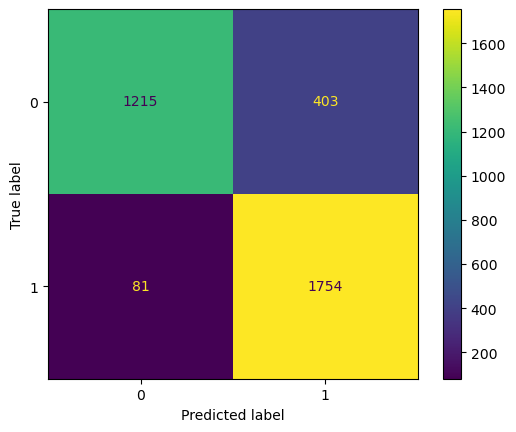

In [12]:
predictions = dt.predict(test_set)

cm = confusion_matrix(test_label, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix = cm)
disp.plot()
plt.show()

In [13]:
pca = PCA(n_components=2)
test_set_reduced = pca.fit_transform(test_set.values)

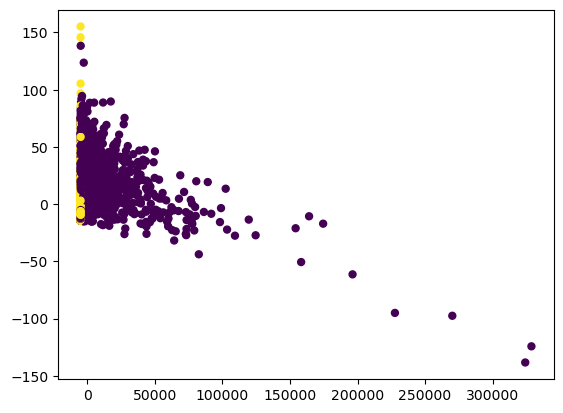

In [14]:
#true labels
from sklearn.datasets import make_blobs
plt.scatter(test_set_reduced[:, 0], test_set_reduced[:, 1], c=test_label, s=25);

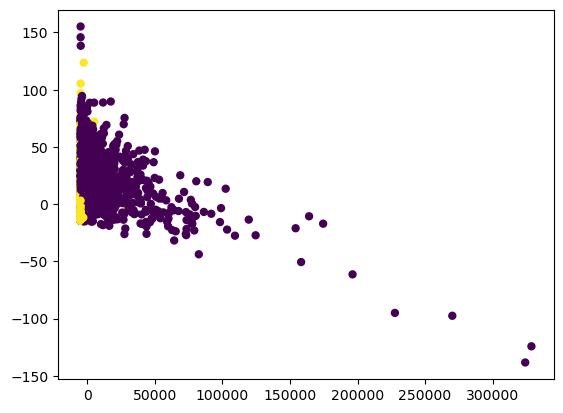

In [15]:
#predicted labels
plt.scatter(test_set_reduced[:, 0], test_set_reduced[:, 1], c=test_pred, s=25);

## Random forest

### Hyperparameter Grid Search

In [16]:
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}

rf = RandomForestClassifier()

grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

grid_search.fit(train_set, train_label)

Fitting 3 folds for each of 288 candidates, totalling 864 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [True], 'max_depth': [80, 90, 100, 110],
                         'max_features': [2, 3], 'min_samples_leaf': [3, 4, 5],
                         'min_samples_split': [8, 10, 12],
                         'n_estimators': [100, 200, 300, 1000]},
             verbose=2)

In [17]:
rf = grid_search.best_estimator_

In [18]:
train_pred = rf.predict(train_set)
test_pred = rf.predict(test_set)

In [19]:
# cross validation
scores = cross_validate(rf, train_set, train_label, cv=3, return_train_score= True)
print('Fit time ', statistics.mean(scores['fit_time']))
print('Score time ', statistics.mean(scores['score_time']))
print('Test score ', statistics.mean(scores['test_score']))
print('Train score ', statistics.mean(scores['train_score']))

Fit time  0.9868621031443278
Score time  0.06883327166239421
Test score  0.8901303538175046
Train score  0.9069522036002483


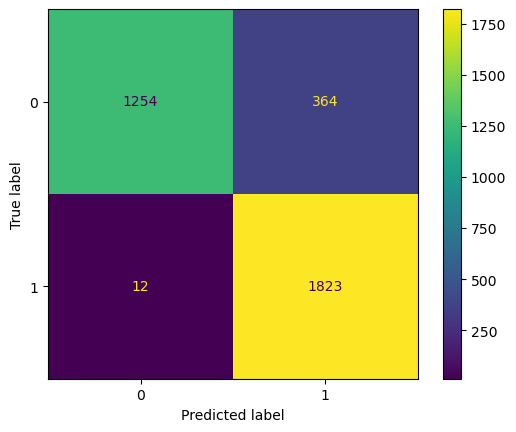

In [20]:
predictions = rf.predict(test_set)

cm = confusion_matrix(test_label, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix = cm)
disp.plot()
plt.show()

In [21]:
pca = PCA(n_components=2)
test_set_reduced = pca.fit_transform(test_set.values)

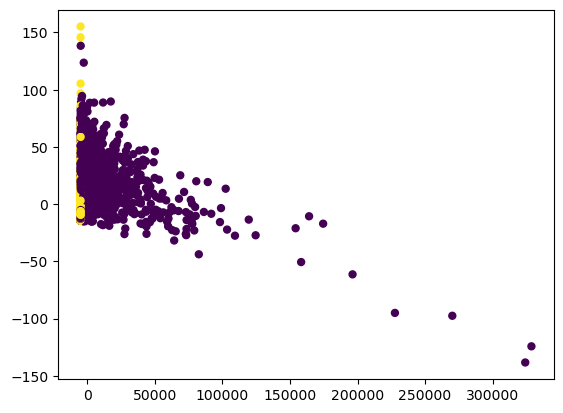

In [22]:
#true labels
from sklearn.datasets import make_blobs
plt.scatter(test_set_reduced[:, 0], test_set_reduced[:, 1], c=test_label, s=25);

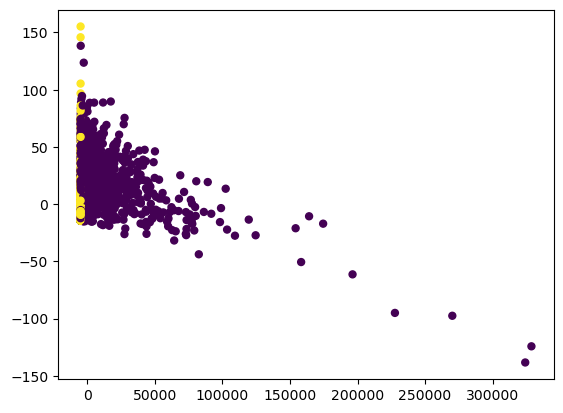

In [23]:
#predicted labels
plt.scatter(test_set_reduced[:, 0], test_set_reduced[:, 1], c=test_pred, s=25);

### Random Hyperparameter Grid Search

In [24]:
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rf = RandomForestClassifier()

rf_random = RandomizedSearchCV(
    estimator = rf,
    param_distributions = random_grid,
    n_iter = 100,
    cv = 3,
    verbose=4,
    random_state=42,
    n_jobs = -1
)

rf_random.fit(train_set, train_label)
print(
    "The best parameters are %s with a score of %0.5f"
    % (rf_random.best_params_, rf_random.best_score_)
)



Fitting 3 folds for each of 100 candidates, totalling 300 fits
The best parameters are {'n_estimators': 1000, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 10, 'bootstrap': True} with a score of 0.89770


In [25]:
rf = rf_random.best_estimator_

In [26]:
train_pred = rf.predict(train_set)
test_pred = rf.predict(test_set)

In [27]:
# cross validation
scores = cross_validate(rf, train_set, train_label, cv=3, return_train_score= True)
print('Fit time ', statistics.mean(scores['fit_time']))
print('Score time ', statistics.mean(scores['score_time']))
print('Test score ', statistics.mean(scores['test_score']))
print('Train score ', statistics.mean(scores['train_score']))

Fit time  3.775713046391805
Score time  0.19028266270955405
Test score  0.8969584109248914
Train score  0.906765983860956


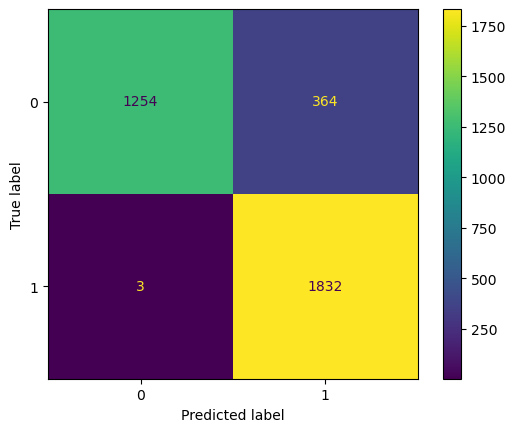

In [28]:
predictions = rf.predict(test_set)

cm = confusion_matrix(test_label, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix = cm)
disp.plot()
plt.show()

In [29]:
pca = PCA(n_components=2)
test_set_reduced = pca.fit_transform(test_set.values)

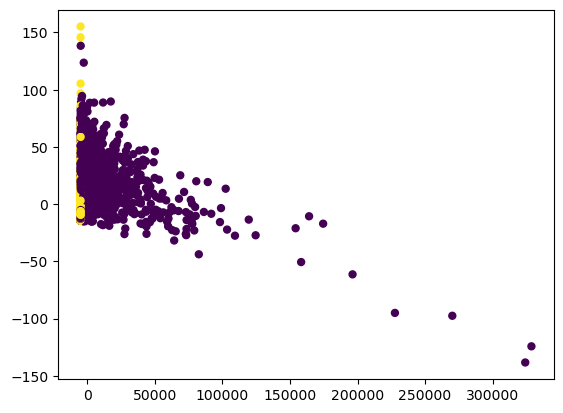

In [30]:
#true labels
from sklearn.datasets import make_blobs
plt.scatter(test_set_reduced[:, 0], test_set_reduced[:, 1], c=test_label, s=25);

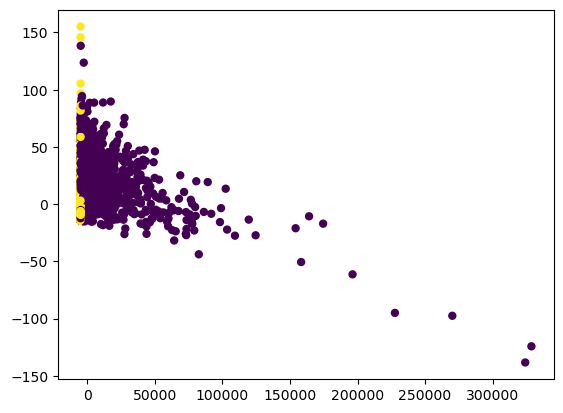

In [31]:
#predicted labels
plt.scatter(test_set_reduced[:, 0], test_set_reduced[:, 1], c=test_pred, s=25);